In [1]:
"""
Aim

You will be provided with data from cardiovascular medicine. You will need to go through the various 
stages of mining this data to develop a predicter. Thus you are expected to filter, clean, and transform 
data as appropriate such that it can be used to produce optimal classification for patient risk. 

{NoRisk, Risk}

 Random - Real number of help in randomly sorting the data records: Should be unique values.

 Session - Anonymous patient session identifier: Should be unique value. Patient can have multiple 
sessions

 Id - Anonymous patient record identifier: Should be unique value per patient. Patient can have 
multiple sessions

 Indication - What type of Cardiovascular event triggered the hospitalisation?
o a-f : Atrial-Fibrillation
o asx : Asymptomatic Stenosis
o cva : Cardiovascular Arrest
o tia : Transient Ischemic Attack ("mini-heart attack")

 Diabetes - Does the patient suffer from Diabetes?

 IHD - Does the patient suffer from Coronary artery disease (CAD), also known as ischemic heart 
disease (IHD)?

 Hypertension - Does the patient suffer from Hypertension?

 Arrhythmia - Does the patient suffer from Arrhythmia (i.e. erratic heart beat)?

 History - Has the patient a history of Cardiovascular interventions?

 IPSI - Percentage figure for cerebral ischemic lesions defined as ipsilateral

 Contra - Percentage figure for contralateral cerebral ischemic lesions

 Label - Is the patient at risk (Mortality)?
"""


%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

In [2]:
# Reading in .csv file and creating a copy to be worked on -->
df = pd.read_csv("./cardio-vascular--ACWData-1.csv")
cardvasc_df = df.copy()
cardvasc_df

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,0.473452,198992,CVA,yes,yes,yes,yes,no,89.0,100,Risk
1,0.218756,253100,CVA,no,no,no,no,no,67.0,100,NoRisk
2,0.131260,155737,CVA,no,yes,yes,no,no,79.0,20,NoRisk
3,0.102954,251222,A-F,no,yes,no,no,no,69.0,40,NoRisk
4,0.236142,197183,CVA,no,no,no,no,no,89.0,30,NoRisk
...,...,...,...,...,...,...,...,...,...,...,...
1515,0.587315,113117,Asx,no,yes,yes,yes,no,74.0,100,Risk
1516,0.932265,103595,CVA,no,yes,yes,no,no,84.0,50,NoRisk
1517,0.876531,211309,CVA,no,no,yes,no,no,76.0,20,NoRisk
1518,0.812032,116379,TIA,no,no,yes,yes,no,75.0,35,NoRisk


In [42]:
# Discovering which values have null/nan elements across the entire DF ready to eliminate or manipulate these elements -->

# NOTE> These will be worked on in the coming code blocks to remove any of these values -->
cardvasc_nan_sum = cardvasc_df.isna().sum()
print(cardvasc_nan_sum)

Random          0
Id              0
Indication      3
Diabetes        2
IHD             0
Hypertension    3
Arrhythmia      0
History         2
IPSI            4
Contra          0
label           3
dtype: int64


In [43]:
"""
Indication - What type of Cardiovascular event triggered the hospitalisation?
    o a-f : Atrial-Fibrillation
    o asx : Asymptomatic Stenosis
    o cva : Cardiovascular Arrest
    o tia : Transient Ischemic Attack ("mini-heart attack")

NOTE> Some rows in "indication" - 'ASx' is sometimes showing as 'Asx'
"""

#---------------------------------------------------------------------The rows with null/nan values are -->
indication_series = cardvasc_df["Indication"] # Series
# # Verifying amount of null/nan values in "Indication"
# indication_nan_sum = indication_series.isna().sum() = 3
# print(f'There are: {indication_nan_sum} null/nan values in Indication')

#-------------------------------------------------------------------------------Counting Trigger Events -->
# Counting the amount of trigger events in "Indication" per event.
indication_value_count = indication_series.value_counts(dropna=False)
print(indication_value_count)

# NOTE> Now there is an acknowledgement that there are 32 incorrectly formatted values (Asx instead of ASx), and the inclusion of 3 nan values (total = 3).

#-----------------------------------------------------------------------REPLACING VALUES in "Indiction" -->
# Some rows in "Indication" ASx is sometimes showing as Asx.
wrong_format = cardvasc_df["Indication"] == "Asx"
wrong_format.value_counts() # 32 values contain "Asx" rather than "ASx".

# Updating the values of "Indiction" where 'Asx' should be 'ASx' 
# NOTE> (will still contain nan at this point).
cardvasc_df.loc[(cardvasc_df["Indication"] == "Asx"), "Indication"] = "ASx"
cardvasc_df["Indication"].value_counts(dropna=False)

# 3 nan values remain at this point in "Indication", but "Asx" has been changed to "ASx" for all instances.
indication_value_count = indication_series.value_counts(dropna=False)
print(indication_value_count)

#----------------Confirming # of nan values by generating a table based on only rows which contain nan -->
indication_value_check = cardvasc_df[(indication_series != "A-F") & (indication_series != "CVA") & (indication_series != "TIA") & (indication_series != "ASx")]
indication_value_check

A-F    493
CVA    416
TIA    390
ASx    186
Asx     32
NaN      3
Name: Indication, dtype: int64
A-F    493
CVA    416
TIA    390
ASx    218
NaN      3
Name: Indication, dtype: int64


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
130,0.761569,256405,NaN,no,no,no,yes,yes,98.0,100,Risk
505,0.648375,261389,NaN,no,yes,yes,no,no,69.0,40,NoRisk
1088,0.211643,206174,NaN,no,yes,no,no,no,79.0,100,Risk


In [44]:
## --
## --
#-------------------------------------------------------------------------------------REPLACING VALUES -->
#----------------Confirming # of nan values by generating a table based on only rows which contain nan -->
# if we were to fill nan values with the most commonly appearing value ("A-F") -->
# values = {"Indication": 'A-F'} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["Indication"].value_counts())

# indication_value_check = cardvasc_df[(indication_series != "A-F") & (indication_series != "CVA") & (indication_series != "TIA") & (indication_series != "ASx")]
# indication_value_check

In [45]:
"""
Diabetes - Does the patient suffer from Diabetes?
"""

diabetes_series = cardvasc_df["Diabetes"] # Series

#---------------------------------------------------Counting the amount of trigger events in "Diabetes" -->
diabetes_value_count = diabetes_series.value_counts(dropna=False)
print(diabetes_value_count)

#----------------------------------------------------------------------------Confirming # of nan values -->
diabetes_value_check = cardvasc_df[(diabetes_series != "yes") & (diabetes_series != "no")]
diabetes_value_check

no     1441
yes      77
NaN       2
Name: Diabetes, dtype: int64


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
43,0.392167,211190,A-F,NaN,no,yes,no,no,79.0,40,NoRisk
1406,0.682026,224586,CVA,NaN,yes,yes,yes,no,89.0,100,Risk


In [46]:
## --
## --
#--------------------------------------------------------------------------------------REPLACING VALUES -->
#----------------------------------------------------------------------------Confirming # of nan values -->
# if we were to fill nan values with the most commonly appearing value ("no") -->
# values = {"Diabetes": 'no'} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["Diabetes"].value_counts())


# diabetes_value_check = cardvasc_df[(diabetes_series != "yes") & (diabetes_series != "no")]
# diabetes_value_check

In [47]:
"""
IHD - Does the patient suffer from Coronary artery disease (CAD), also known as ischemic heart 
disease (IHD)?
"""

ihd_series = cardvasc_df["IHD"] # Series

#-----------------------------------------------------------Counting the amount trigger events in "IHD" -->
ihd_value_count = ihd_series.value_counts(dropna=False)
print(ihd_value_count)

#----------------------------------------------------------------------------Confirming # of nan values -->
idh_value_check = cardvasc_df[(ihd_series != "yes") & (ihd_series != "no")]
idh_value_check

no     801
yes    719
Name: IHD, dtype: int64


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label


In [48]:
"""
Hypertension - Does the patient suffer from Hypertension?
"""

hypertension_series = cardvasc_df["Hypertension"] # Series

#-----------------------------------------------------------Counting the amount trigger events in "IHD" -->
hypertension_value_count = hypertension_series.value_counts(dropna=False)
print(hypertension_value_count)

# NOTE> Now there is an acknowledgement that there are 3 nan values (total = 6).

#----------------------------------------------------------------------------Confirming # of nan values -->
hypertension_value_check = cardvasc_df[(hypertension_series != "yes") & (hypertension_series != "no")]
hypertension_value_check

no     784
yes    733
NaN      3
Name: Hypertension, dtype: int64


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
21,0.388824,240561,CVA,yes,no,NaN,yes,no,94.0,90,Risk
805,0.708255,289425,A-F,no,no,NaN,no,no,77.0,30,NoRisk
1222,0.319190,158353,TIA,no,no,NaN,no,no,74.0,75,NoRisk


In [49]:
## --
## --
#--------------------------------------------------------------------------------------REPLACING VALUES -->
#----------------------------------------------------------------------------Confirming # of nan values -->
# if we were to fill nan values with the most commonly appearing value ("A-F") -->
# values = {"Hypertension": 'no'} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["Hypertension"].value_counts())

# hypertension_value_check = cardvasc_df[(hypertension_series != "yes") & (hypertension_series != "no")]
# hypertension_value_check

In [50]:
"""
Arrhythmia - Does the patient suffer from Arrhythmia (i.e. erratic heart beat)?
"""

arrhythmia_series = cardvasc_df["Arrhythmia"] # Series

#-----------------------------------------------------------Counting the amount trigger events in "IHD" -->
arrhythmia_value_count = arrhythmia_series.value_counts(dropna=False)
print(arrhythmia_value_count)

#----------------------------------------------------------------------------Confirming # of nan values -->
arrhythmia_value_check = cardvasc_df[(arrhythmia_series != "yes") & (arrhythmia_series != "no")]
arrhythmia_value_check

no     1190
yes     330
Name: Arrhythmia, dtype: int64


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label


In [51]:
"""
History - Has the patient a history of Cardiovascular interventions?
"""

history_series = cardvasc_df["History"] # Series

#-----------------------------------------------------------Counting the amount trigger events in "IHD" -->
history_value_count = history_series.value_counts(dropna=False)
print(history_value_count)

# NOTE> Now there is an acknowledgement that there are 2 nan values (total = 8).

#----------------------------------------------------------------------------Confirming # of nan values -->
history_value_check = cardvasc_df[(history_series != "yes") & (history_series != "no")]
history_value_check

no     1494
yes      24
NaN       2
Name: History, dtype: int64


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
54,0.617300,261099,CVA,no,yes,no,no,NaN,84.0,50,NoRisk
1163,0.243556,196812,CVA,no,no,yes,yes,NaN,94.0,100,Risk


In [52]:
## --
## --
#--------------------------------------------------------------------------------------REPLACING VALUES -->
#----------------------------------------------------------------------------Confirming # of nan values -->
# if we were to fill nan values with the most commonly appearing value ("A-F") -->
# values = {"History": 'no'} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["History"].value_counts())

# history_value_check = cardvasc_df[(history_series != "yes") & (history_series != "no")]
# history_value_check

In [53]:
"""
IPSI - Percentage figure for cerebral ischemic lesions defined as ipsilateral
"""

ipsi_series = cardvasc_df["IPSI"] # Series
ipsi_series

#-----------------------------------------------------------Counting the amount trigger events in "IHD" -->
ipsi_value_count = ipsi_series.value_counts(dropna=False)
# print(ipsi_value_count)

# Verifying amount of null/nan values in "IPSI".
ipsi_nan_sum = ipsi_series.isna().sum()
print(f'There are: {ipsi_nan_sum} null/nan values in Indication')

ipsi_value_check = cardvasc_df[cardvasc_df["IPSI"].isna()]
ipsi_value_check


# NOTE> Now there is an acknowledgement that there are 4 nan values (total = 12).

There are: 4 null/nan values in Indication


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
46,0.004209,282008,A-F,no,no,no,no,no,NaN,50,NoRisk
89,0.243429,146744,CVA,no,yes,yes,yes,no,NaN,100,Risk
134,0.283817,228108,A-F,no,no,no,no,no,NaN,100,Risk
464,0.920581,104505,CVA,no,no,no,no,no,NaN,20,NoRisk


In [54]:
## --
## --
#--------------------------------------------------------------------------------------REPLACING VALUES -->
#----------------------------------------------------------------------------Confirming # of nan values -->
# if we were to fill nan values with the most commonly appearing value ("A-F") -->
# values = {"IPSI": 69.0} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["IPSI"].value_counts())

# ipsi_value_check = cardvasc_df["IPSI"].isnull().values.sum()
# print(f'There are: {ipsi_value_check} null/nan values in IPSI')

# ipsi_value_check2 = cardvasc_df[cardvasc_df["IPSI"].isna()]
# ipsi_value_check2

In [55]:
"""
Contra - Percentage figure for contralateral cerebral ischemic lesions

NOTE> there is a " " in "Contra" which needs filling as nan (then strip out all the nans from their indexes)
"""

# Counting the amount trigger events in "Contra" -->
contra_series = cardvasc_df["Contra"]
contra_value_count = contra_series.value_counts(dropna=False)
# 1 empty space is discovered after looking at the value counts -->
# print(contra_value_count)

# Verifying that there is an string with a space within the column -->
contra_space_count = (contra_series.values == " ").sum()
print(f'There is: {contra_space_count} empty value in Contra')

# Finding the index where the space is positioned -->
contra_space_input = cardvasc_df.index[cardvasc_df["Contra"] == " "]
space_index = cardvasc_df.loc[contra_space_input]
space_index
# print(f'The empty index of this is: {space_index}')

There is: 1 empty value in Contra


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
642,0.518702,254798,ASx,no,no,yes,no,no,69.0,,NoRisk


In [56]:
#------------------------------REPLACING " " with nan in "Contra"---------------------------------
cardvasc_df.loc[contra_series == " ", "Contra"] = np.nan
contra_nan_values = contra_series.isna().sum()
print(f'There is: {contra_nan_values} nan value in Contra')

# contra_value_count = contra_series.value_counts(dropna=False)
# print(contra_value_count)
# contra_value_count.dtype

contra_series = pd.to_numeric(cardvasc_df["Contra"])
contra_value_check = cardvasc_df[cardvasc_df["Contra"].isna()]
contra_value_check

There is: 1 nan value in Contra


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
642,0.518702,254798,ASx,no,no,yes,no,no,69.0,NaN,NoRisk


In [57]:
## --
## --
#-------------------------------------------------------------------------REPLACING VALUES -->
# if we were to fill nan values with the most commonly appearing value ("A-F") -->
# values = {"Contra": 100} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["Contra"].value_counts())

#----------------------------------------------------------------------------Confirming # of nan values -->
# contra_value_check = cardvasc_df["Contra"].isnull().values.sum()
# print(contra_value_check)

# contra_value_check2 = cardvasc_df[cardvasc_df["Contra"].isna()]
# contra_value_check2

In [58]:
"""
Label - Is the patient at risk (Mortality)?

NOTE> There are 2 "unknown" in label so these need converting to nan as well and need dropping
"""

label_series = cardvasc_df["label"] # Series

# Counting the amount trigger events in "IHD" -->
# label_value_count = label_series.value_counts(dropna=False)
# print(label_value_count)

# #------------------------------REPLACING "unknown" with nan in "label"---------------------------------
cardvasc_df.loc[label_series == "Unknown", "label"] = np.nan
# label_nan_values = label_series.isna().sum()
# print(f'There are: {label_nan_values} nan value in Contra')
print()

# Re-counting the amount trigger events in "label" --> ("Unknown" changed to nan)
label_value_count = cardvasc_df["label"].value_counts(dropna=False)
print(label_value_count)

# Changing 'label' into 0's and 1s, re-naming to 'Label' for consistency -->
label_series_dummies = pd.Series(label_series.map({"Risk": 1, "NoRisk": 0}), name="Label")

# Dropping the nan values here that it can be Label Binarized -->
label_series.dropna(inplace=True)

# Add label_series_dummies back in to working df -->
cardvasc_df = pd.concat([cardvasc_df, label_series_dummies], axis=1, ignore_index=False)

Label_nan_values = cardvasc_df["Label"].isna().sum()
print(f'There are: {Label_nan_values} nan value in Label')
# Display values which now contain nan -->
label_value_check = cardvasc_df[cardvasc_df["Label"].isna()]
label_value_check



NoRisk    1008
Risk       507
NaN          5
Name: label, dtype: int64
There are: 5 nan value in Label


,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,Label
155,0.813495,170055,TIA,yes,no,no,no,yes,89.0,50,NaN,NaN
202,0.923905,165761,CVA,no,yes,yes,yes,no,79.0,70,NaN,NaN
471,0.757284,191000,CVA,no,yes,yes,no,no,75.0,50,NaN,NaN
1415,0.298031,174120,ASx,no,yes,yes,no,no,69.0,55,NaN,NaN
1467,0.460265,284175,CVA,no,no,yes,yes,no,94.0,100,NaN,NaN


In [59]:
## --
## --
#--------------------------------------------------------------------------------------REPLACING VALUES -->
# if we were to fill nan values with the most commonly appearing value ("A-F") -->
# values = {"Label": 0.0} # creating the values to insert
# cardvasc_df.fillna(value = values, inplace=True) # inplace modifies original DataFrame
# print(cardvasc_df["Label"].value_counts())

#----------------------------------------------------------------------------Confirming # of nan values -->
# label_value_check = cardvasc_df["Label"].isnull().values.sum()
# print(label_value_check)

# label_value_check2 = cardvasc_df[cardvasc_df["Label"].isna()]
# label_value_check2

In [60]:
#------------------------------DROPPING na/null VALUES FROM ROWS---------------------------------
# Dropping null/nan values from df rows where they appear per described column -->
cardvasc_df.dropna(subset=["Indication", "Diabetes", "Hypertension", "History", "IPSI", "Contra", "label", "Label"], inplace=True)

cardvasc_df.isna().sum()

Random          0
Id              0
Indication      0
Diabetes        0
IHD             0
Hypertension    0
Arrhythmia      0
History         0
IPSI            0
Contra          0
label           0
Label           0
dtype: int64

In [61]:
#------------------------------CHANGING "Label" TYPE TO int FROM float---------------------------------
cardvasc_df["Label"] = cardvasc_df["Label"].astype(np.int64)
cardvasc_df

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,Label
0,0.473452,198992,CVA,yes,yes,yes,yes,no,89.0,100,Risk,1
1,0.218756,253100,CVA,no,no,no,no,no,67.0,100,NoRisk,0
2,0.131260,155737,CVA,no,yes,yes,no,no,79.0,20,NoRisk,0
3,0.102954,251222,A-F,no,yes,no,no,no,69.0,40,NoRisk,0
4,0.236142,197183,CVA,no,no,no,no,no,89.0,30,NoRisk,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0.587315,113117,ASx,no,yes,yes,yes,no,74.0,100,Risk,1
1516,0.932265,103595,CVA,no,yes,yes,no,no,84.0,50,NoRisk,0
1517,0.876531,211309,CVA,no,no,yes,no,no,76.0,20,NoRisk,0
1518,0.812032,116379,TIA,no,no,yes,yes,no,75.0,35,NoRisk,0


In [62]:
#------------------------------DROPPING attributes from Dataframe---------------------------------
# Dropping specific columns ready for model training -->
cardvasc_df.drop(columns=["Random", "Id", "label"], axis=1, inplace=True)

cardvasc_df

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,Label
0,CVA,yes,yes,yes,yes,no,89.0,100,1
1,CVA,no,no,no,no,no,67.0,100,0
2,CVA,no,yes,yes,no,no,79.0,20,0
3,A-F,no,yes,no,no,no,69.0,40,0
4,CVA,no,no,no,no,no,89.0,30,0
...,...,...,...,...,...,...,...,...,...
1515,ASx,no,yes,yes,yes,no,74.0,100,1
1516,CVA,no,yes,yes,no,no,84.0,50,0
1517,CVA,no,no,yes,no,no,76.0,20,0
1518,TIA,no,no,yes,yes,no,75.0,35,0


In [63]:
# Generating dummy values for certain attributes -->
cardvasc_df_dummies = pd.DataFrame(cardvasc_df, columns=["Indication", "Diabetes", "IHD", "Hypertension", "Arrhythmia", "History"])
dummies = pd.get_dummies(cardvasc_df_dummies)
dummies

,Indication_A-F,Indication_ASx,Indication_CVA,Indication_TIA,Diabetes_no,Diabetes_yes,IHD_no,IHD_yes,Hypertension_no,Hypertension_yes,Arrhythmia_no,Arrhythmia_yes,History_no,History_yes
0,0,0,1,0,0,1,0,1,0,1,0,1,1,0
1,0,0,1,0,1,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1,1,0,1,0
3,1,0,0,0,1,0,0,1,1,0,1,0,1,0
4,0,0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0,1,0,0,1,0,0,1,0,1,0,1,1,0
1516,0,0,1,0,1,0,0,1,0,1,1,0,1,0
1517,0,0,1,0,1,0,1,0,0,1,1,0,1,0
1518,0,0,0,1,1,0,1,0,0,1,0,1,1,0


In [64]:
concat_df = pd.DataFrame(cardvasc_df, columns=["IPSI", "Contra", "Label"])
concat_df
dummies_df = pd.concat([concat_df, dummies], axis=1) # adding the columns together!

# THIS IS THE WORKING DATA FROM HERE ON (must be clean and entail these values) -->
dummies_df

,IPSI,Contra,Label,Indication_A-F,Indication_ASx,Indication_CVA,Indication_TIA,Diabetes_no,Diabetes_yes,IHD_no,IHD_yes,Hypertension_no,Hypertension_yes,Arrhythmia_no,Arrhythmia_yes,History_no,History_yes
0,89.0,100,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0
1,67.0,100,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
2,79.0,20,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0
3,69.0,40,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
4,89.0,30,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,74.0,100,1,0,1,0,0,1,0,0,1,0,1,0,1,1,0
1516,84.0,50,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0
1517,76.0,20,0,0,0,1,0,1,0,1,0,0,1,1,0,1,0
1518,75.0,35,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0


In [65]:
# CODE HAS BEEN CLEANED AND RE-COMPILED UP TO THIS POINT. 
# THE REMAINING IS MODEL IMPLEMENTATION -->

In [66]:
x = dummies_df.drop(["Label"], axis=1) # everything but the Label 
y = dummies_df["Label"] # GROUND TRUTH (Risk/No Risk)

# DETERMINE HOW ACCURATE THE MODEL IS -->
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70, test_size=0.30, shuffle=True)

[303   2  28 117]


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

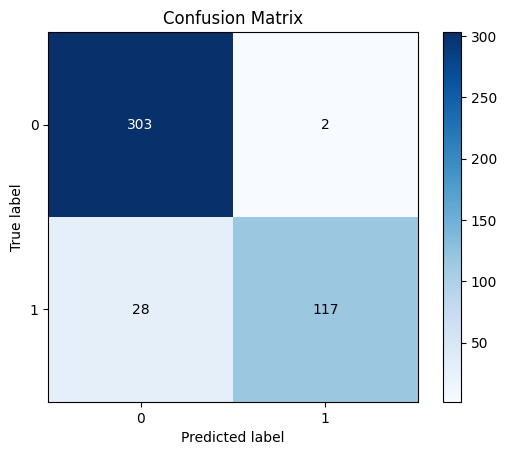

In [67]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(solver='sgd', activation='logistic', max_iter=50000) # chaging "max_iter" affets results

#--------------------------------------------------------------------------------------Neural Network -->

mlp_model.fit(x_train, y_train)

mlp_pred = mlp_model.predict(x_test)
# mlp_pred


cm = confusion_matrix(y_test, mlp_pred).ravel()
print(cm)


skplt.metrics.plot_confusion_matrix(y_test, mlp_pred) # GT vs PREDICTION

In [68]:

accuracy = accuracy_score(y_test, mlp_pred)

print(accuracy * 100)

93.33333333333333


In [69]:
kf = KFold(n_splits=5, shuffle=True)

results = cross_validate(estimator=mlp_model, X=x_train, y=y_train, cv=kf)

print(f'The cross-validation scores using cross_val_score method are: {(results["test_score"])}')
mean_result = results["test_score"]
np.mean(mean_result)

The cross-validation scores using cross_val_score method are: [0.96190476 0.91904762 0.84285714 0.92380952 0.92380952]


0.9142857142857144

[302   3   2 143]


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

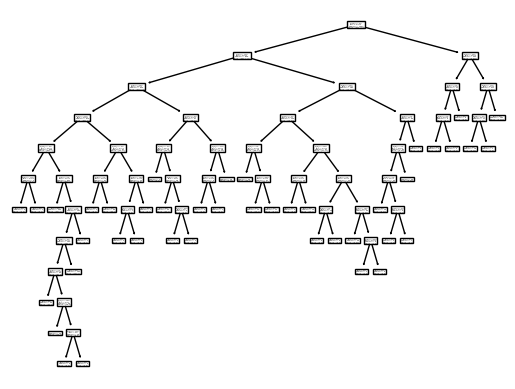

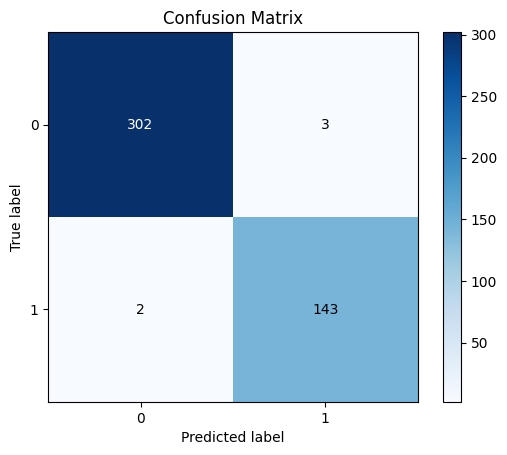

In [70]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier() # make a new model

dtc_model.fit(x_train, y_train) # input data / actual value
dtc_pred = dtc_model.predict(x_test)

from sklearn.tree import plot_tree # only available on Scikit-learn > v0.21

plot_tree(dtc_model) # features_names param -->

# CONFUSION MATRIX
cm = confusion_matrix(y_test, dtc_pred).ravel()
print(cm)

skplt.metrics.plot_confusion_matrix(y_test, dtc_pred) # GT vs PREDICTION

In [71]:
accuracy = accuracy_score(y_test, dtc_pred)

print(accuracy * 100)

98.88888888888889


The cross-validation scores using cross_val_score method are: [1.         0.97619048 0.99047619 0.98571429 0.98571429]


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

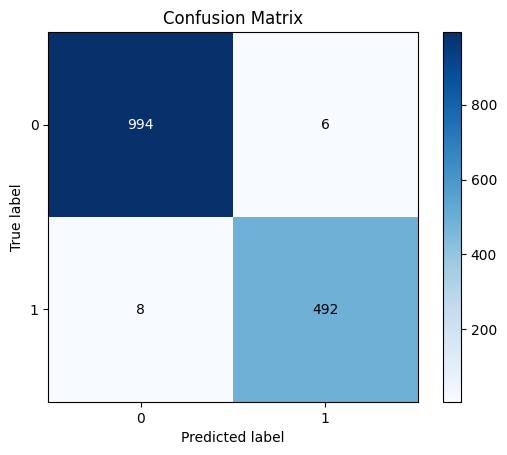

In [72]:
kf = KFold(n_splits=5, shuffle=True)

results = cross_validate(estimator=dtc_model, X=x_train, y=y_train, cv=kf)

print(f'The cross-validation scores using cross_val_score method are: {(results["test_score"])}')
mean_result = results["test_score"]
np.mean(mean_result)

y_pred = cross_val_predict(dtc_model, x, y, cv=10)
mat = confusion_matrix(y, y_pred).ravel()

skplt.metrics.plot_confusion_matrix(y, y_pred) # GT vs PREDICTION

In [73]:
# # REGRESSION MODEL -->
# from sklearn.linear_model import LinearRegression 
# lg = LinearRegression() 

# # reshaped_x_train = np.asarray(x_train["Contra"]).reshape(-1, 1) 
# # reshaped_y_train = np.asarray(y_train).reshape(-1, 1) 

# # print( "Train X: " , reshaped_x_train.shape) 
# # print( "Train Y: " , reshaped_y_train.shape) 

# reg_model = lg.fit(x_train, y_train)
# reg_model

# lg_pred = lg.predict(x_test).ravel()
# print(lg_pred)

In [74]:
# pred2 = reg_model.predict(np.asarray(x_test).reshape(-1, 1)).ravel()
# print(pred2)

[0.16932406 0.26473668 0.03012681 0.00939198 0.00853808 0.00877385
 0.01941305 0.01101084 0.02747797 0.00869042 0.04615445 0.03408079
 0.21657339 0.14393072 0.00141836 0.00035854]


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

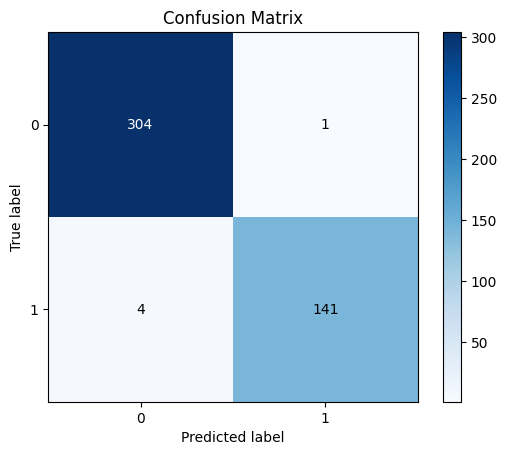

In [75]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=5)

rf_model.fit(x_train, y_train)
print(rf_model.feature_importances_)

rf_model.score(x_train, y_train)

rf_pred = rf_model.predict(x_test)
# print(rf_pred)

# CONFUSION MATRIX
cm = confusion_matrix(y_test, rf_pred).ravel()
# print(cm)

skplt.metrics.plot_confusion_matrix(y_test, rf_pred) # GT vs PREDICTION

In [76]:
accuracy = accuracy_score(y_test, rf_pred)
print(accuracy)

0.9888888888888889


In [77]:
# TAKEN FROM "Label" section

# SOMEHOW NEED TO CHANGE TO INT WITHOUT EFFECTING THE MODEL FIT --> ...
# from sklearn.preprocessing import LabelBinarizer
# lb = LabelBinarizer()

# lb.fit(label_series)
# # label_series_dummies_formatted = pd.Series({"Label": label_series})
# # print(label_series_dummies_formatted)

# label = lb.transform(label_series).ravel()
# print(f'g2 is: {label}') # True and False 
# label_series_dummies_formatted = pd.Series(label, name="Label")
# label_series_dummies_formatted